In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light50_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Mar  9 20:57:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 99%   84C    P0   100W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 91%   

In [3]:
save_dir = 'save/light50_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0  save_3431  save_720


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 720

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 243.6MiB
TTS size 156.0MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
loaded : 720
720
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.013411784172058105


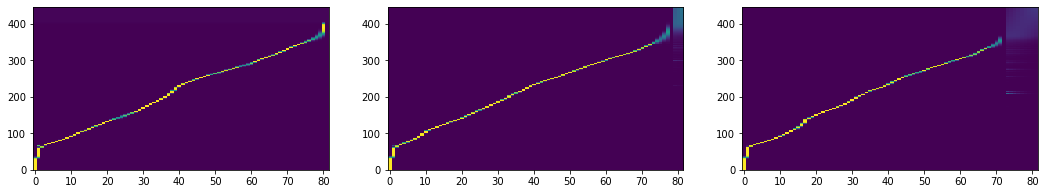

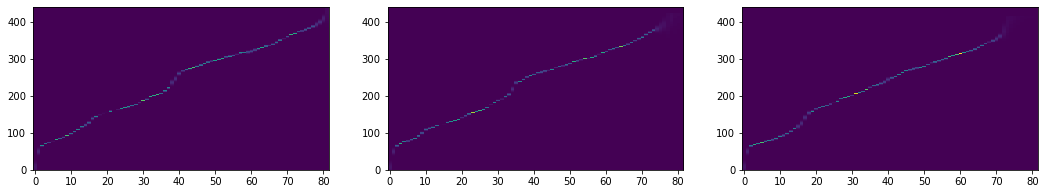

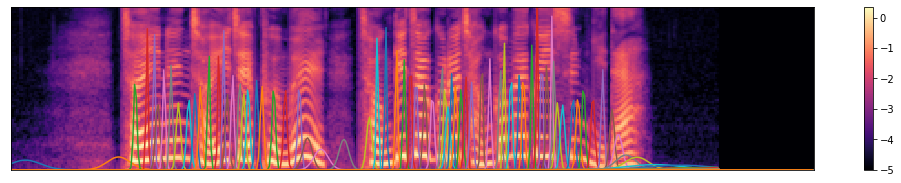

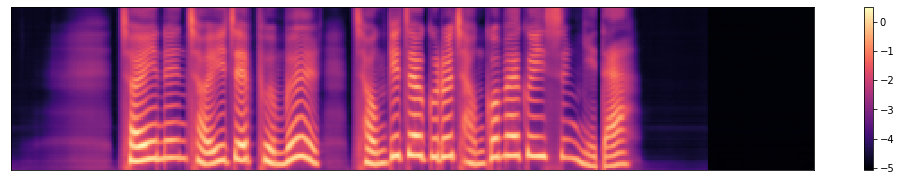

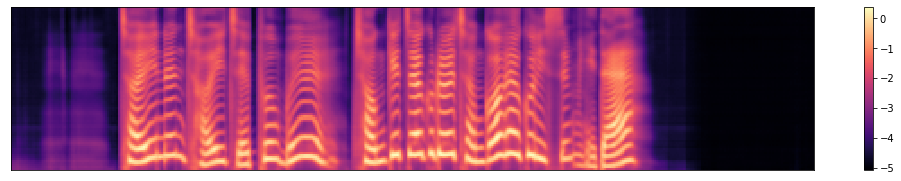

tensor(0.2930, device='cuda:0')
step : 24201 stt : 0.0057 tts : 0.1321 recon : 0.0194 kl : 0.0131 beta : 0.4842
tensor(0.2469, device='cuda:0')
step : 24202 stt : 0.0063 tts : 0.1279 recon : 0.0199 kl : 0.0139 beta : 0.4842
tensor(0.2817, device='cuda:0')
step : 24203 stt : 0.0074 tts : 0.1511 recon : 0.0231 kl : 0.0158 beta : 0.4842
tensor(0.2676, device='cuda:0')
step : 24204 stt : 0.0069 tts : 0.1266 recon : 0.0216 kl : 0.0148 beta : 0.4842
tensor(0.3205, device='cuda:0')
step : 24205 stt : 0.0077 tts : 0.1347 recon : 0.0178 kl : 0.0127 beta : 0.4842
tensor(0.3189, device='cuda:0')
step : 24206 stt : 0.0065 tts : 0.1397 recon : 0.0227 kl : 0.0154 beta : 0.4843
tensor(0.2600, device='cuda:0')
step : 24207 stt : 0.0056 tts : 0.1162 recon : 0.0178 kl : 0.0125 beta : 0.4843
tensor(0.2341, device='cuda:0')
step : 24208 stt : 0.0057 tts : 0.1505 recon : 0.0228 kl : 0.0157 beta : 0.4843
tensor(0.2739, device='cuda:0')
step : 24209 stt : 0.0071 tts : 0.1440 recon : 0.0219 kl : 0.0147 beta :

KeyboardInterrupt: 

In [42]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [ ]:
logger.save(step, model, optimizer)

torch.Size([1, 80, 536]) 0.00852104663848877
{'alignment': 0.00043010711669921875, 'random': 0.0001373291015625, 'last_conv': 0.0033416748046875, 'z_proj': 0.00015282630920410156, 'cond': 0.0005688667297363281, 'up': 0.00025773048400878906, 'encode': 0.003119945526123047, 'pad': 3.218650817871094e-05, 'enc_conv': 0.0007569789886474609, 'enc_lstm': 0.002245187759399414}


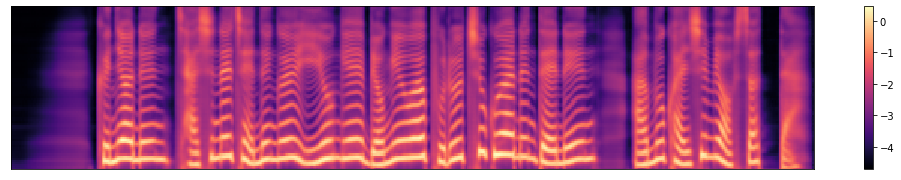

In [60]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(100):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=0.3)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [61]:
print(batch['strings'][0])
print(batch['text'][0])

그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.
tensor([  0, 234, 183, 184, 235, 133, 128, 235, 138, 148,  32, 236, 158, 144,
        236, 139, 160, 236, 157, 152,  32, 236, 158, 172, 235, 138, 165, 236,
        157, 132,  32, 236, 157, 180, 236, 154, 169, 237, 149, 180,  32, 235,
        170, 133, 236, 152, 136, 236, 153, 128,  32, 235, 182, 128, 235, 165,
        188,  32, 236, 182, 148, 234, 181, 172, 237, 149, 152, 235, 138, 148,
         32, 235, 141, 176, 235, 138, 148,  32, 236, 149, 132, 235, 172, 180,
         32, 234, 180, 128, 236, 139, 172, 236, 157, 180,  32, 236, 151, 134,
        236, 151, 136, 235, 139, 164,  46,   0], device='cuda:0')


In [62]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.04
random 0.01
last_conv 0.30
z_proj 0.01
cond 0.05
up 0.02
encode 0.28
pad 0.00
enc_conv 0.07
enc_lstm 0.20


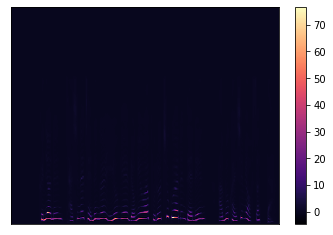

In [63]:
def denormalize(x):
    return 10 ** x

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)